# Aircraft Predictive Maintenance
The goal of this project (P1) is to predict if an aircraft engine will fail during an incoming cycle, based on historical operational data and sensor informations. In the next projects we will gradually look at different components of our aircraft. 
In this specific case we will test different ML approaches and rate the algorithm before engaging into discussion with our friends and colleagues.

## Importing Libriaires

In [77]:
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import os
from tqdm import tqdm
import plotly.graph_objects as go
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, LSTM, Activation, SimpleRNN, GRU
import xgboost as xgb

%matplotlib inline

## Seeding for reproducibility

In [2]:
np.random.seed(9876)  
PYTHONHASHSEED = 0

## Importing dataset
In this specific example the dataset have already been splitted. We are loading the training dataset where the failure point is provided, as well as the testing dataset where the failule is not provided.
The data are provided initially as a zip-compressed text file with 26 columns of numbers, separated by spaces. Each row is a snapshot of data taken during a single operational cycle, each column is a different variable. The columns correspond to: 1) unit number 2) time, in cycles 3) operational setting 1 4) operational setting 2 5) operational setting 3 6) sensor measurement 1 7) sensor measurement 2 ... 26) sensor measurement 26. (IT WOULD BE GOOD TO PUT A DESCRIPTION OF THE SENSORS HERE)

In [3]:
# Loading training and testing dataset - This example will need to be enriched with entire dataset.
train_df = pd.read_csv('predictive_maintenance_p1_data/PM_train.txt', sep=" ", header=None)

# Test data where the failure point is not given for the engines
test_df = pd.read_csv('predictive_maintenance_p1_data/PM_test.txt', sep=" ", header=None)

# Also provided a vector of true Remaining Useful Life (RUL) values for the test data.
truth_df = pd.read_csv('predictive_maintenance_p1_data/PM_truth.txt', sep=" ", header=None)

In [4]:
# We wil print some rows of the train data
train_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN


In [5]:
# We wil print some rows of the train data
test_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,NaN,NaN
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,NaN,NaN
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,NaN,NaN


In [6]:
# We wil print some rows of the truth RUL data
truth_df.head(3)

,0
0,112
1,98
2,69


## Data cleaning 
Step 1 - Remove the columns that contains entirely NaN

In [7]:
train_df.dropna(axis=1, inplace=True)
test_df.dropna(axis=1, inplace=True)
print(f"the length of the training dataset is {len(train_df)}")
print(f"the length of the testing dataset is {len(test_df)}")

the length of the training dataset is 20631
the length of the testing dataset is 13096


## Renaming columns

In [8]:
cols_names = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

train_df.columns = cols_names
test_df.columns = cols_names

train_df.head(2)

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236


# Processing Data 
## Adding the Remaining Useful Life metrics (in cycles)
In this section, we will calculate the Remaining Useful Life (RUL) for each engine at each cycle. The RUL is computed by subtracting the current cycle number of an engine from the maximum cycle observed for that engine (based on its ID). This gives us the number of cycles remaining before the engine is expected to fail.

In [9]:
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')

#Actual RUL value calculation is next:
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


## Adding will be used as target variables
Target variables are for training a model to predict whether an engine is approaching failure and how urgently maintenance is needed. On this case we will test if the failure is likely to happen within ***x*** circle in ***w1*** cariable.

In [10]:
# We will make a label that indicates whether an engine is going to fail within w1 cycles. On thge 
w0 = 30
train_df['failure_within_w0'] = np.where(train_df['RUL'] <= w0, 1, 0 )
train_df.head(3)

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,RUL,failure_within_w0
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0


## Data normalisation 
### Normalization of Training Data
Using MinMax Normalization, We will normalise the data that will be use in the prediction model, including the cycle.
We need to provide more information on the method MinMax Scaler or a link for students to learn more about it.

In [11]:
# MinMax normalization
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','failure_within_w0'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)
train_df.head(3)

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,RUL,failure_within_w0,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0.00000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0.00277
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0.00554


### Normalization of Testing Data

In [12]:
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.220588,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.264706,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.220588,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.250000,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.220588,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108


# Importing Ground Truth data to the test dataset

In [13]:
# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm,RUL
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138


## Adding target variable for test dataset 

In [14]:
test_df['failure_within_w0'] = np.where(test_df['RUL'] <= w0, 1, 0 )
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,cycle_norm,RUL,failure_within_w0
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142,0
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141,0
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140,0
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139,0
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138,0


# Exploratory Data Analysis
## Plottting all the sensor data for engine ID:1
The following chart is dynamic, we can turn off the display of some sensors. This chart also help us to quickly see that some sensor have data stable at ***0*** or ***1***.

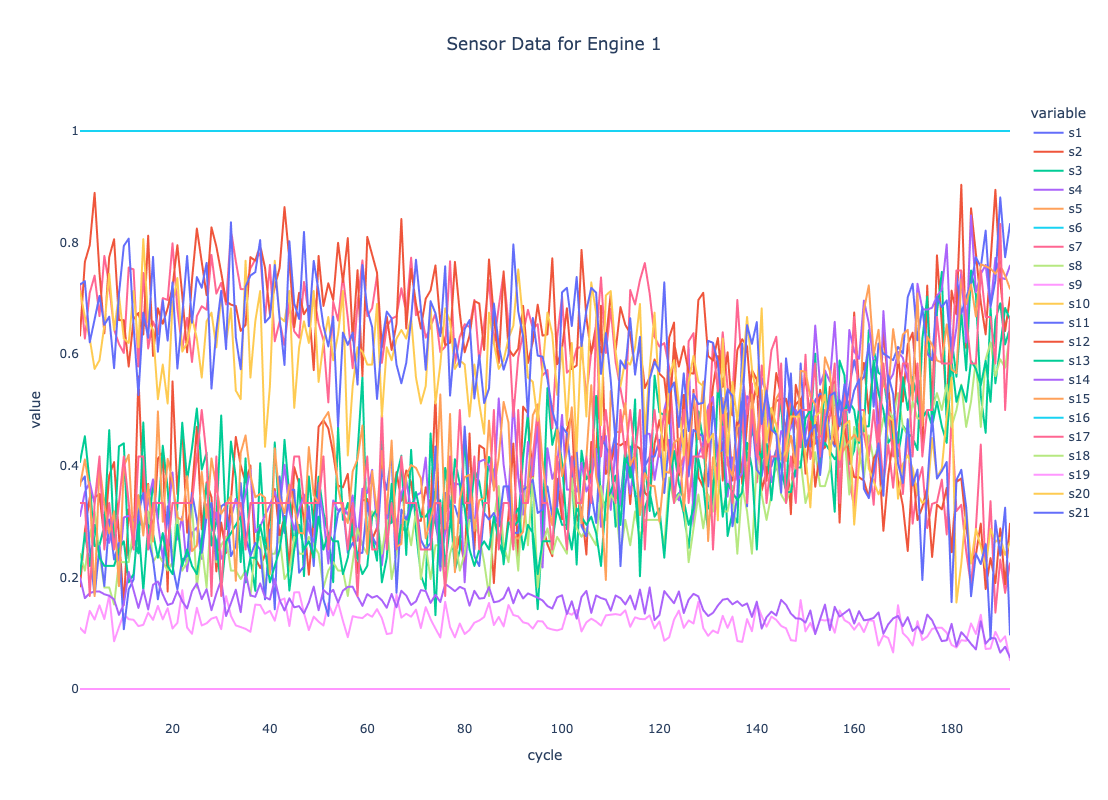

In [15]:
sensor_cols = cols_names[5:]

fig = px.line(train_df[train_df.id == 1], x='cycle', y=sensor_cols, title="Sensor Data for Engine 1")

fig.update_layout(
    plot_bgcolor='white', 
    paper_bgcolor='white', 
    title={'x': 0.5}, 
    height=800
)

fig.show()

## Plottting a specific the sensor data for engine ID:1

In [16]:
sensor_col = sensor_cols[1]  # We must choose any sensor column here

fig = px.line(train_df[train_df['id'] == 1], x='cycle', y=sensor_col, 
              title=f'{sensor_col} Sensor Data for Engine 1')
fig.update_layout(xaxis_title='Cycle', yaxis_title=sensor_col)
fig.show()

## Distribution of Cycles & RUL (Remaining Useful Life)

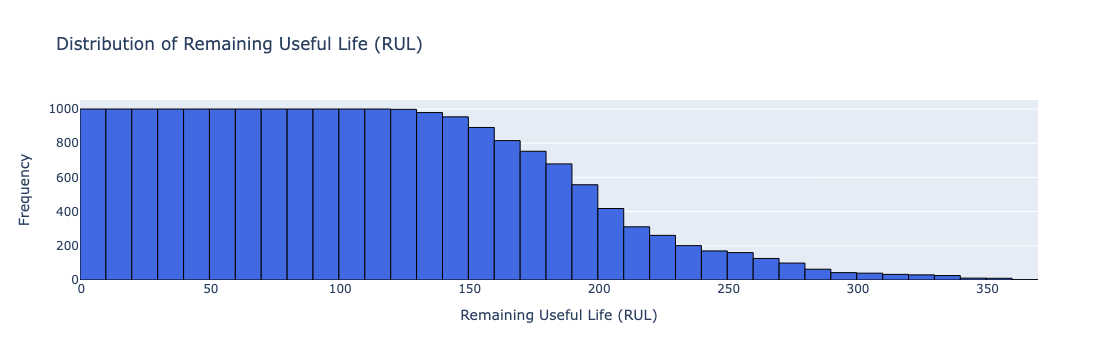

In [17]:

fig = px.histogram(train_df, x='RUL', nbins=50, title='Distribution of Remaining Useful Life (RUL)', 
                   labels={'RUL': 'Remaining Useful Life (RUL)'})
fig.update_traces(marker=dict(color='royalblue', line=dict(width=1, color='black')))
fig.update_layout(xaxis_title='Remaining Useful Life (RUL)', yaxis_title='Frequency')
fig.show()


Engine Failure Count (How Many Engines Fail and When)

## Correlation Heatmap of Sensors

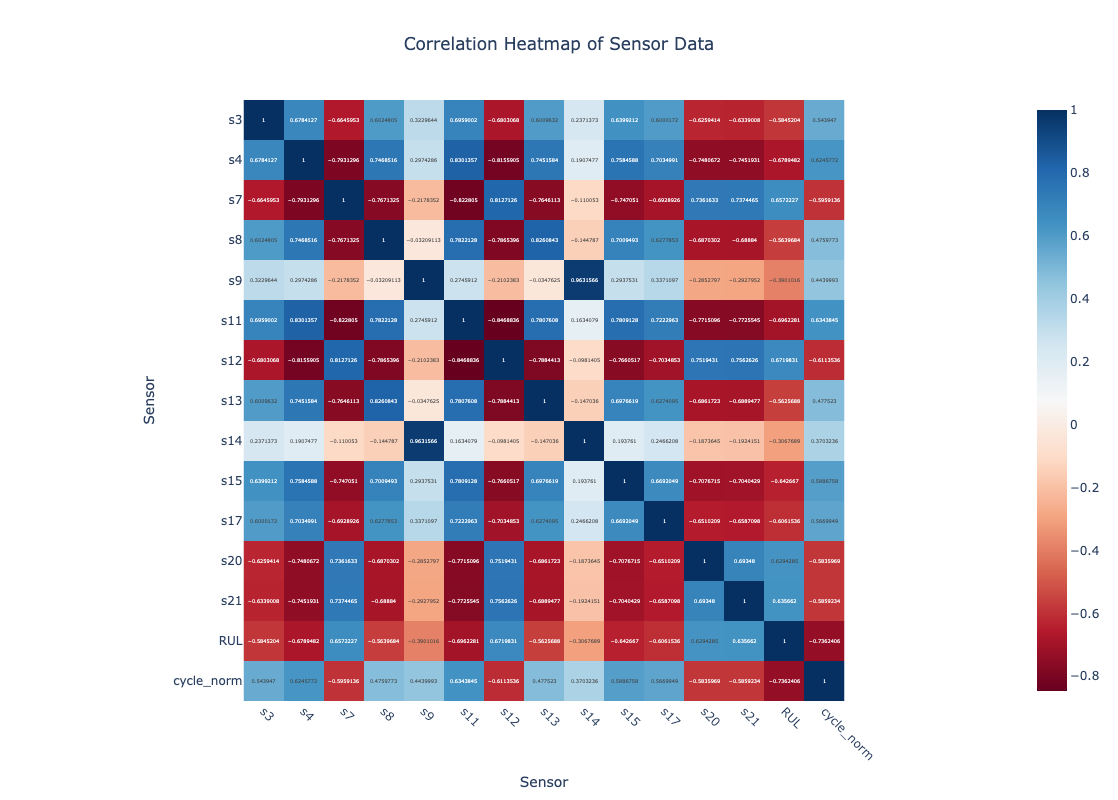

In [18]:
# Remove columns where the entire column is 0 or 1
train_df_cleaned = train_df.loc[:, ~train_df.isin([0, 1]).all()]

# Now, update sensor_cols to reflect only the remaining columns in the cleaned dataset
# Make sure sensor_cols refers to the columns from the cleaned DataFrame
sensor_cols = train_df_cleaned.columns[5:]  # assuming the sensor columns are from column index 5 onwards

# Now calculate the correlation matrix
corr = train_df_cleaned[sensor_cols].corr()

# Create a Plotly heatmap
fig = px.imshow(corr, text_auto=True, color_continuous_scale='RdBu', title='Correlation Heatmap of Sensor Data')

# Update the layout for better readability
fig.update_layout(
    width=1000,  # Increase the width
    height=800,  # Increase the height
    xaxis_title='Sensor',
    yaxis_title='Sensor',
    xaxis=dict(
        tickmode='array',
        tickvals=np.arange(len(sensor_cols)),
        ticktext=sensor_cols,
        tickangle=45,  # Rotate x-axis labels for readability
    ),
    yaxis=dict(
        tickmode='array',
        tickvals=np.arange(len(sensor_cols)),
        ticktext=sensor_cols,
    ),
    plot_bgcolor='white',
    title_x=0.5
)

fig.show()


## Engine Failure Count (How Many Engines Fail and When)

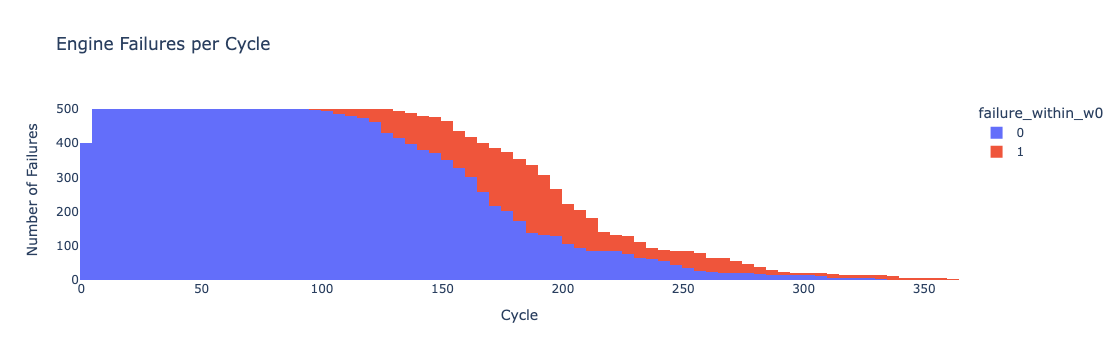

In [19]:
fig = px.histogram(train_df, x='cycle', color='failure_within_w0', 
                   title='Engine Failures per Cycle', 
                   labels={'failure_within_w1': 'Failure Status', 'cycle': 'Cycle'})
fig.update_layout(
    xaxis_title='Cycle',
    yaxis_title='Number of Failures',
    barmode='stack',  # Stack bars to differentiate failure/non-failure
    plot_bgcolor='white'
)
fig.show()


## Box Plots for Sensor Data Over Different Engines

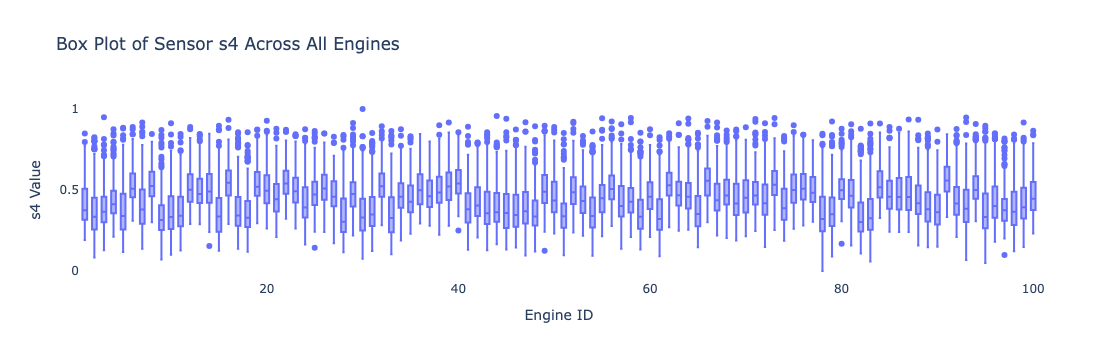

In [20]:
fig = px.box(train_df, x='id', y=sensor_cols[1], 
             title=f'Box Plot of Sensor {sensor_cols[1]} Across All Engines')
fig.update_layout(
    xaxis_title='Engine ID',
    yaxis_title=f'{sensor_cols[1]} Value',
    plot_bgcolor='white'
)
fig.show()


In [21]:
# preparing data for visualizations 
# window of 50 cycles prior to a failure point for engine id 3
engine_id3 = test_df[test_df['id'] == 3]
engine_id3_50cycleWindow = engine_id3[engine_id3['RUL'] <= engine_id3['RUL'].min() + 50]
cols1 = ['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10']
engine_id3_50cycleWindow1 = engine_id3_50cycleWindow[cols1]
cols2 = ['s11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
engine_id3_50cycleWindow2 = engine_id3_50cycleWindow[cols2]

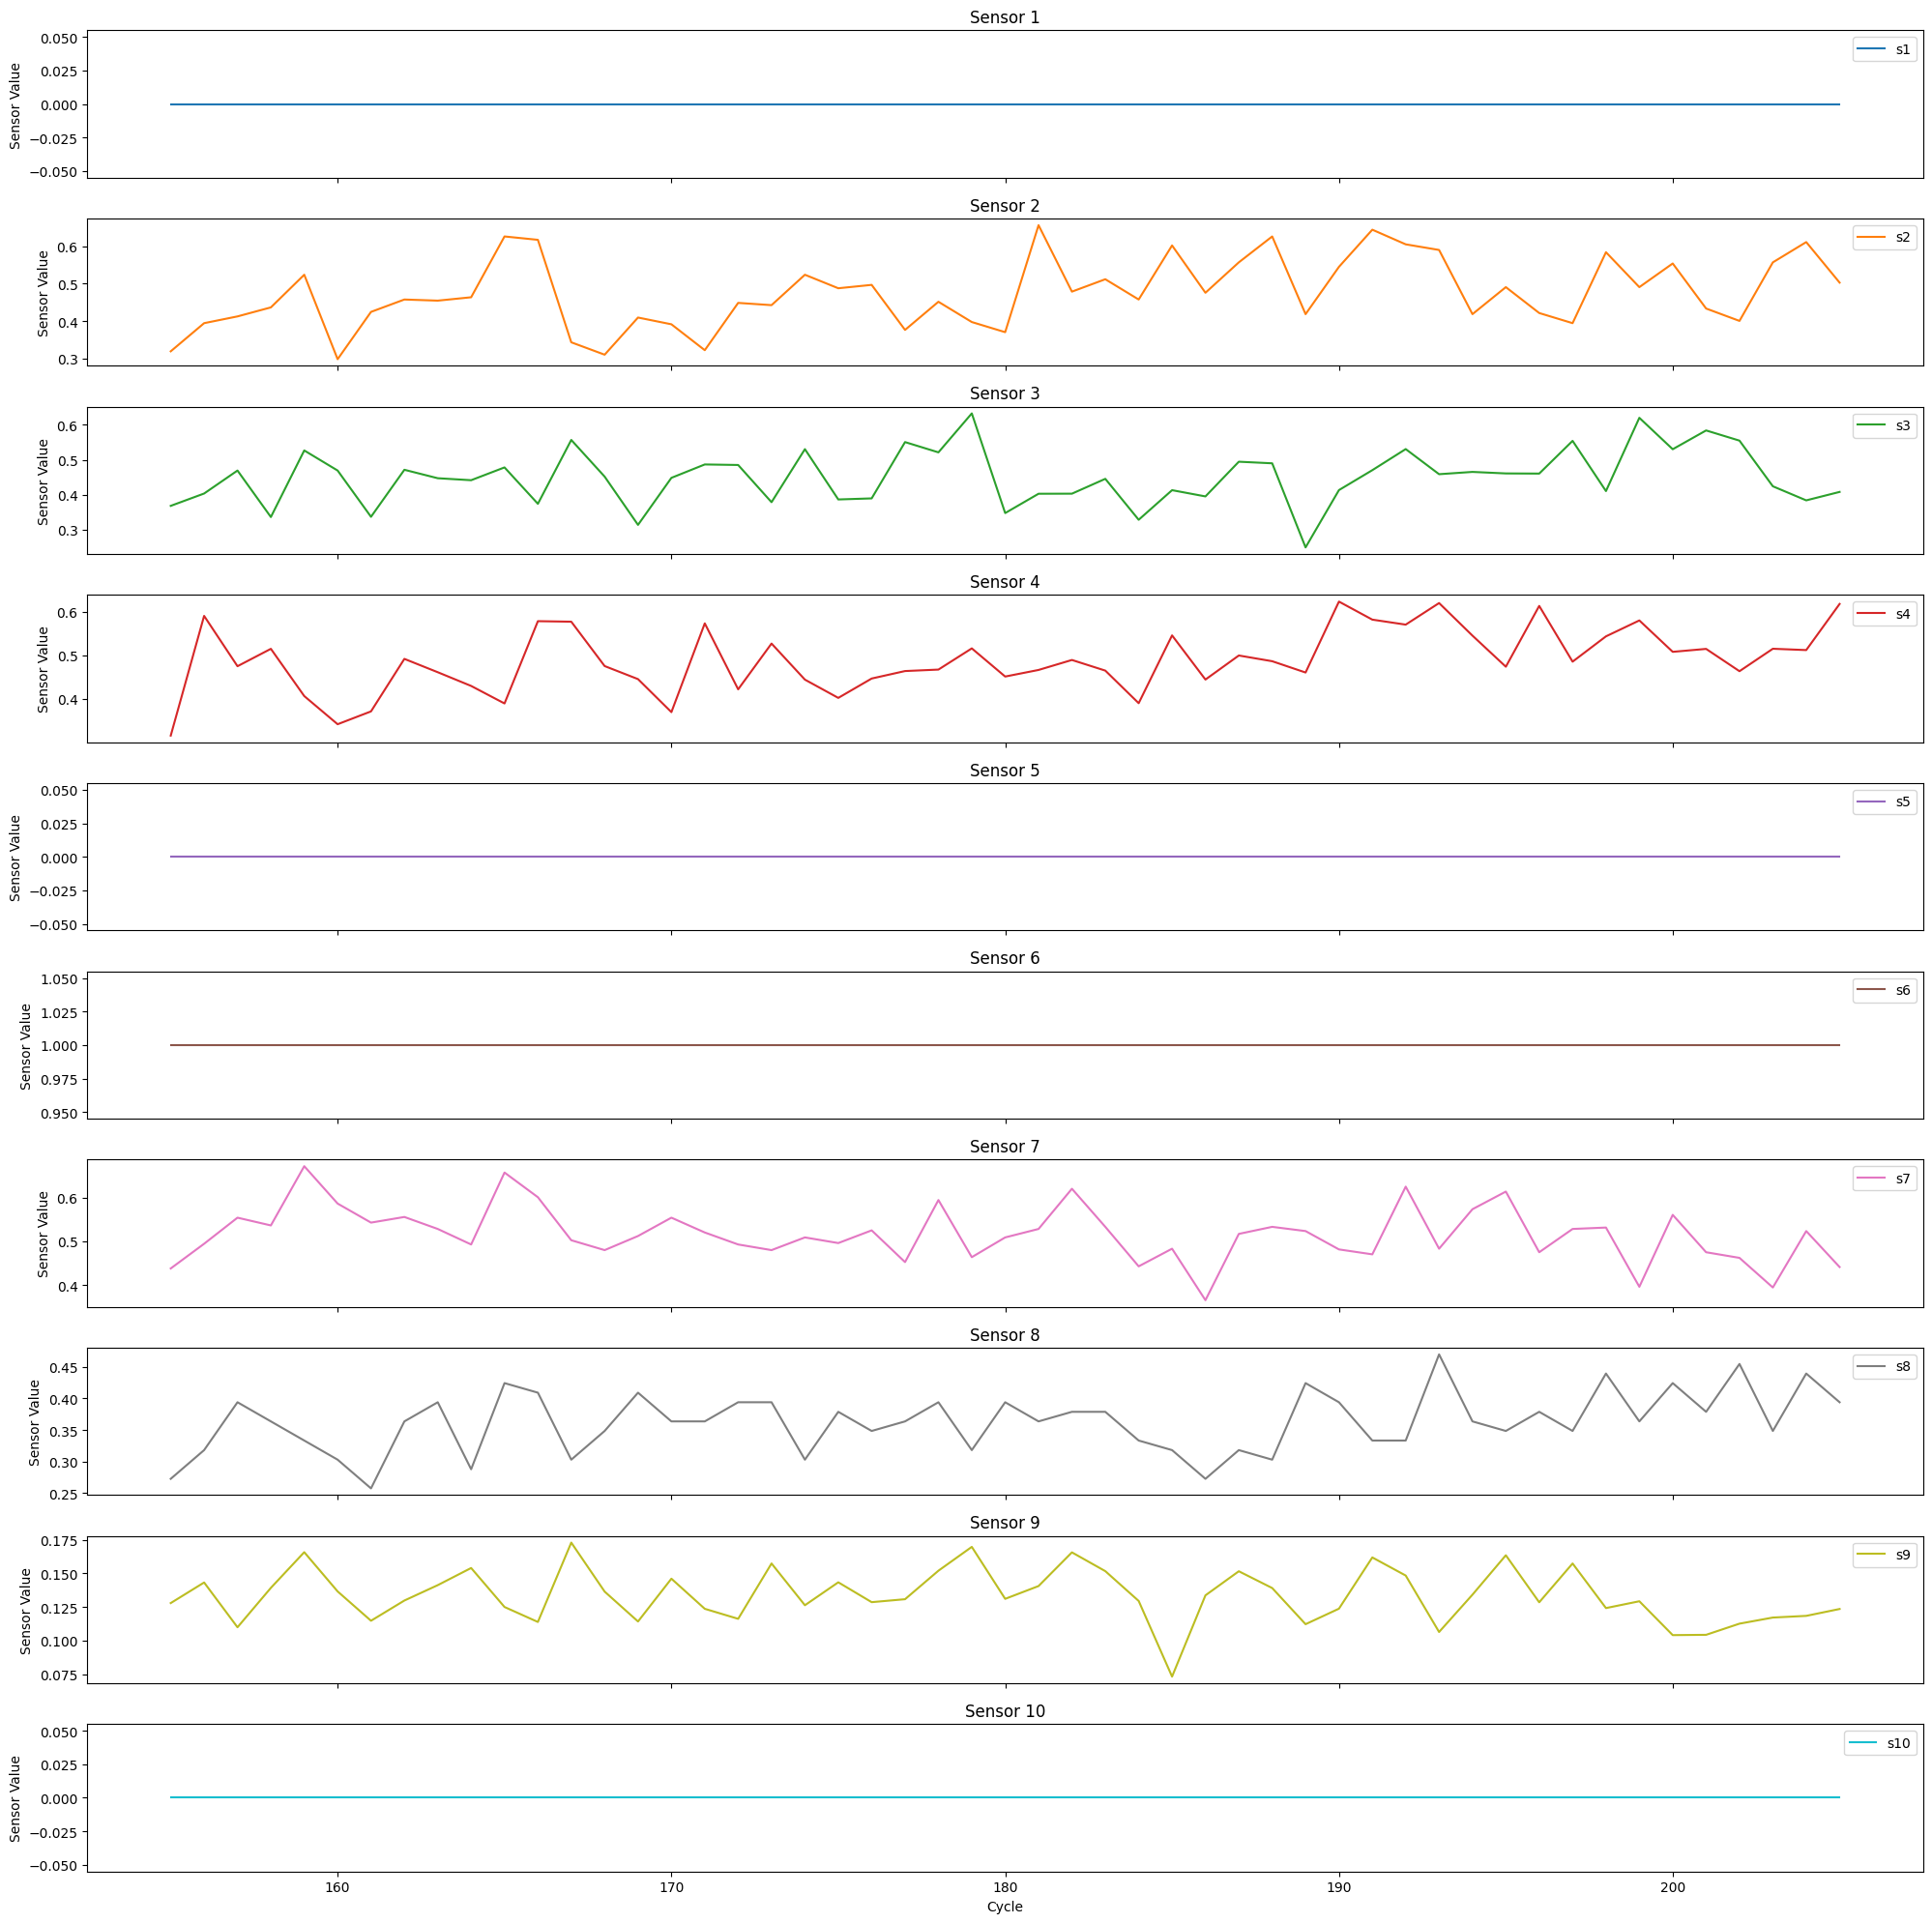

In [22]:
import matplotlib.pyplot as plt

# Assuming engine_id3_50cycleWindow1 is your DataFrame

# Create subplots for sensor data, with individual titles
ax1 = engine_id3_50cycleWindow1.plot(subplots=True, sharex=True, figsize=(20, 20))

# Set titles for each subplot
for i, axis in enumerate(ax1):
    axis.set_title(f"Sensor {i + 1}")  # You can change the title format here
    axis.set_xlabel("Cycle")           # Optionally set x-axis label
    axis.set_ylabel("Sensor Value")    # Optionally set y-axis label

# Show the plot
plt.tight_layout()
plt.show()


# RNN on 25 Features
## Generating Sequences
We generate sequences to transform raw time-series sensor data into short consecutive windows that capture recent system behavior. Each sequence represents how parameters evolve over time, allowing the model to learn temporal patterns that precede failures. This step converts the dataset into the format required for sequence models like RNNs or LSTMs — (samples, timesteps, features) — and increases the number of training examples using overlapping windows. In predictive maintenance, it helps the model predict whether an engine is likely to fail soon based on the most recent sequence of readings rather than isolated data points. We will be generating sequence for a specific sensor across all the engine's ID.

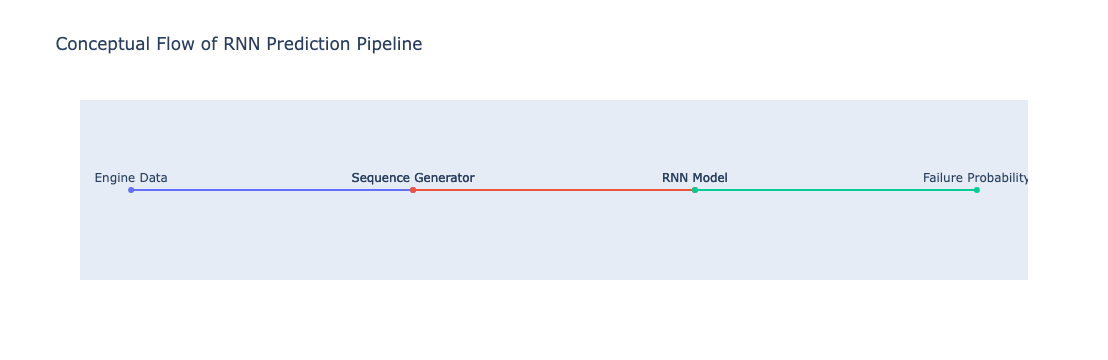

In [26]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=[0, 1], y=[2, 2], text=["Engine Data", "Sequence Generator"], mode="lines+markers+text", textposition="top center"))
fig.add_trace(go.Scatter(x=[1, 2], y=[2, 2], text=["Sequence Generator", "RNN Model"], mode="lines+markers+text", textposition="top center"))
fig.add_trace(go.Scatter(x=[2, 3], y=[2, 2], text=["RNN Model", "Failure Probability"], mode="lines+markers+text", textposition="top center"))

fig.update_layout(title="Conceptual Flow of RNN Prediction Pipeline",
                  xaxis=dict(visible=False), yaxis=dict(visible=False), showlegend=False)
fig.show()


In [28]:
sequence_length = 50
def sequence_generator(feature_df, seq_length, seq_cols):
    feature_array = feature_df[seq_cols].values
    num_elements = feature_array.shape[0]
    
    for start, stop in zip(range(0, num_elements - seq_length), range(seq_length, num_elements)):
        yield feature_array[start:stop, :]

In [32]:
import numpy as np

sequence_length = 50

def sequence_generator(df, seq_length, seq_cols):
    """
    Generate sequences for a single engine (or any group of rows).
    
    Args:
        df (pd.DataFrame): DataFrame filtered for a single engine.
        seq_length (int): Length of each sequence (number of timesteps).
        seq_cols (list): Columns/features to include in sequences.
        
    Yields:
        np.ndarray: Sequence of shape (seq_length, n_features)
    """
    feature_array = df[seq_cols].values
    num_elements = feature_array.shape[0]
    
    for start, stop in zip(range(0, num_elements - seq_length), range(seq_length, num_elements)):
        yield feature_array[start:stop, :]

# Define feature columns
sensor_cols = [f's{i}' for i in range(1, 22)]
sequence_cols_25 = ['setting1', 'setting2', 'setting3', 'cycle_norm'] + sensor_cols

# Generate sequences for all engines
seq_list = [
    seq
    for engine_id in train_df['id'].unique()
    for seq in sequence_generator(train_df[train_df['id'] == engine_id], sequence_length, sequence_cols_25)
]

# Convert list of sequences to NumPy array once
seq_set_f25 = np.array(seq_list, dtype=np.float32)

print("Sequences shape:", seq_set_f25.shape)


Sequences shape: (15631, 50, 25)


In [38]:
def generate_label_sequences(df, seq_length, label_col):
    """
    Generate labels aligned with sequences.
    Each label corresponds to the last timestep of the sequence.
    """
    labels = df[label_col].values
    return np.array([labels[start + seq_length] for start in range(len(labels) - seq_length)])

label_list = [
    generate_label_sequences(train_df[train_df['id'] == engine_id], sequence_length, 'failure_within_w0')
    for engine_id in train_df['id'].unique()
]
label_set = np.concatenate(label_list)
print("Label shape aligned with sequences:", label_set.shape)


Label shape aligned with sequences: (15631,)


In this step, we build and compile a Recurrent Neural Network (RNN) to predict whether an aircraft engine will fail within a specific time window.
We first define the input and output dimensions based on our preprocessed sequence data (seq_set_f25) and labels (label_set).
Then, we construct a two-layer RNN using SimpleRNN layers to learn temporal patterns from the sensor readings over time.
The network ends with a dense layer with a sigmoid activation to output a binary prediction (failure or not).
Finally, we compile the model using binary cross-entropy loss and the Adam optimizer, ready for training.

In [39]:
features_dim = seq_set_f25.shape[2] # number of features (25).
out_dim = label_set_aligned.shape[1] if len(label_set_aligned.shape) > 1 else 1

print("Features dimension: ", features_dim)
print("Output dimension: ", out_dim)

RNN_fwd_2 = Sequential()

# Understanding return_sequences and the connection across RNN layers:
# We have to return the sequences from the first layer so the next layer can get the sequence.

RNN_fwd_2.add(SimpleRNN(
         input_shape=(sequence_length, features_dim),
         units=5,
         return_sequences=True))
RNN_fwd_2.add(Dropout(0.2))

RNN_fwd_2.add(SimpleRNN(
          units=3,
          return_sequences=False))
RNN_fwd_2.add(Dropout(0.2))

RNN_fwd_2.add(Dense(units=out_dim, activation='sigmoid'))

# Compile the model.
RNN_fwd_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(RNN_fwd_2.summary())

# Define the path to save the model.
RNN_fwd_2_path = 'rnn_fwd2_path.keras'
RNN_by_path = 'rnn_fwd2_path.keras'

Features dimension:  25
Output dimension:  1


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, 50, 5)          │           155 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 3)              │            27 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 186 (744.00 B)

 Trainable params: 186 (744.00 B)

 Non-trainable params: 0 (0.00 B)

None


# Training RNN model 

In [40]:
import time
epochs = 200
batch_size = 200
start = time.time()

# Fit the network.
RNN_fwd_2_history = RNN_fwd_2.fit(seq_set_f25, label_set, epochs=epochs, batch_size=batch_size, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(RNN_fwd_2_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )
end = time.time()
print("Total time taken for training: ", "{:.2f}".format((end-start)), " secs")

Epoch 1/200
75/75 - 2s - 20ms/step - accuracy: 0.6844 - loss: 0.5746 - val_accuracy: 0.8107 - val_loss: 0.4780
Epoch 2/200
75/75 - 1s - 7ms/step - accuracy: 0.8242 - loss: 0.4272 - val_accuracy: 0.9437 - val_loss: 0.3280
Epoch 3/200
75/75 - 1s - 7ms/step - accuracy: 0.8988 - loss: 0.3568 - val_accuracy: 0.9412 - val_loss: 0.2890
Epoch 4/200
75/75 - 1s - 7ms/step - accuracy: 0.9054 - loss: 0.3215 - val_accuracy: 0.9412 - val_loss: 0.2592
Epoch 5/200
75/75 - 1s - 8ms/step - accuracy: 0.9132 - loss: 0.2920 - val_accuracy: 0.9412 - val_loss: 0.2382
Epoch 6/200
75/75 - 1s - 9ms/step - accuracy: 0.9207 - loss: 0.2694 - val_accuracy: 0.9425 - val_loss: 0.2258
Epoch 7/200
75/75 - 1s - 8ms/step - accuracy: 0.9257 - loss: 0.2541 - val_accuracy: 0.9399 - val_loss: 0.2089
Epoch 8/200
75/75 - 1s - 7ms/step - accuracy: 0.9292 - loss: 0.2415 - val_accuracy: 0.9450 - val_loss: 0.2034
Epoch 9/200
75/75 - 1s - 7ms/step - accuracy: 0.9296 - loss: 0.2315 - val_accuracy: 0.9463 - val_loss: 0.2020
Epoch 10/

In [41]:
import matplotlib.pyplot as plt

def plot_training_curve(history, width=10, height=10):
    plt.figure(figsize=(width, height))
    plt.plot(history.history['loss'], label='train loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='val loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_model_accuracy(history, width=10, height=10):
    plt.figure(figsize=(width, height))
    
    # Try common keys for accuracy
    acc_key = None
    for key in ['accuracy', 'acc', 'binary_accuracy']:
        if key in history.history:
            acc_key = key
            break
            
    if acc_key is None:
        print("⚠️ No accuracy metric found in history")
        return
    
    plt.plot(history.history[acc_key], label='train acc')
    val_acc_key = 'val_' + acc_key
    if val_acc_key in history.history:
        plt.plot(history.history[val_acc_key], label='val acc')
        
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


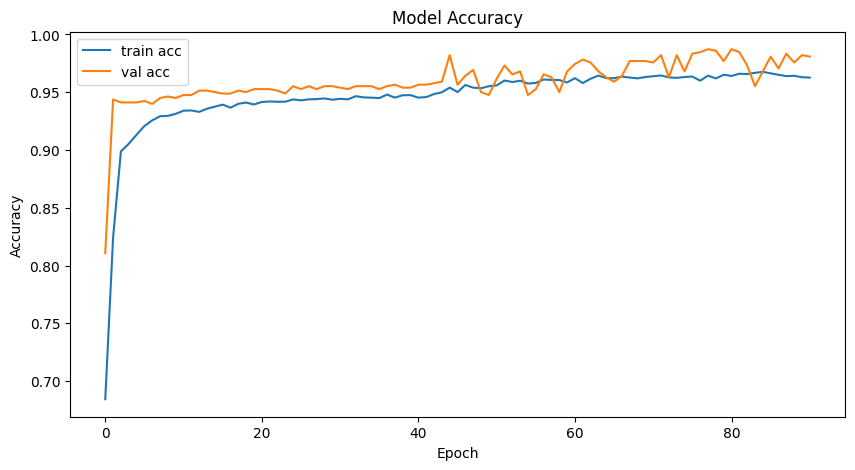

In [44]:
plot_model_accuracy(RNN_fwd_2_history,10,5)


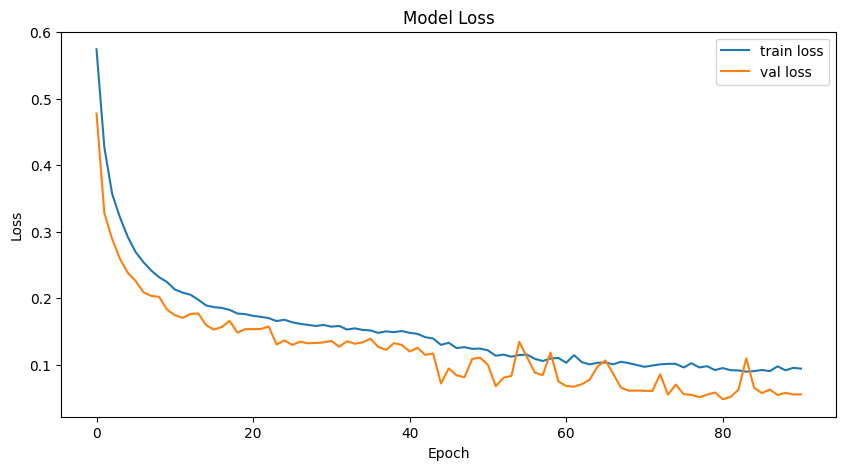

In [46]:
plot_training_curve(RNN_fwd_2_history,10,5)


In [57]:
def analyze_model_on_train_set(
    input_sequences: np.ndarray,
    labels: np.ndarray,
    model,
    batch_size_eval: int = 50,
    batch_size_pred: int = 200,
    save_predictions: bool = False,
    predictions_path: str = 'binary_submit_train.csv'
):
    """
    Evaluate a Keras model on the training set, compute metrics, and optionally save predictions.
    
    Args:
        input_sequences (np.ndarray): Input sequences for the model.
        labels (np.ndarray): True labels aligned with the sequences.
        model: Trained Keras model.
        batch_size_eval (int): Batch size for model.evaluate().
        batch_size_pred (int): Batch size for model.predict().
        save_predictions (bool): If True, saves predictions to a CSV file.
        predictions_path (str): Path to save the CSV if save_predictions=True.
        
    Returns:
        dict: Dictionary with accuracy, confusion matrix, precision, recall.
    """
    # Evaluate
    loss, accuracy = model.evaluate(input_sequences, labels, verbose=1, batch_size=batch_size_eval)
    print(f"Train Accuracy: {accuracy:.4f}")

    # Predict
    y_pred = (model.predict(input_sequences, verbose=1, batch_size=batch_size_pred) > 0.5).astype("int32")
    y_true = labels

    if save_predictions:
        pd.DataFrame(y_pred).to_csv(predictions_path, index=False)
        print(f"Predictions saved to {predictions_path}")

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion matrix\n- x-axis: true labels\n- y-axis: predicted labels")
    print(cm)

    # Precision and recall
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    print(f"Train Precision = {precision:.4f}\nTrain Recall = {recall:.4f}")

    return {
        'accuracy': accuracy,
        'confusion_matrix': cm,
        'precision': precision,
        'recall': recall
    }

# Usage
results = analyze_model_on_train_set(seq_set_f25, label_set_aligned, RNN_fwd_2, save_predictions=True)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9759 - loss: 0.0588
Train Accuracy: 0.9718
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Predictions saved to binary_submit_train.csv
Confusion matrix
- x-axis: true labels
- y-axis: predicted labels
[[12403   128]
 [  313  2787]]
Train Precision = 0.9561
Train Recall = 0.8990


Using model: rnn_fwd2_path.keras
2/2 - 0s - 87ms/step - accuracy: 0.9462 - loss: 0.1083
Total inference time: 0.19 secs
Test Accuracy: 0.9462
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Predictions saved to binary_submit_test.csv
Confusion matrix (x-axis: true, y-axis: predicted):
[[65  3]
 [ 2 23]]
Test Precision: 0.8846
Test Recall: 0.9200
Test F1-score: 0.9020


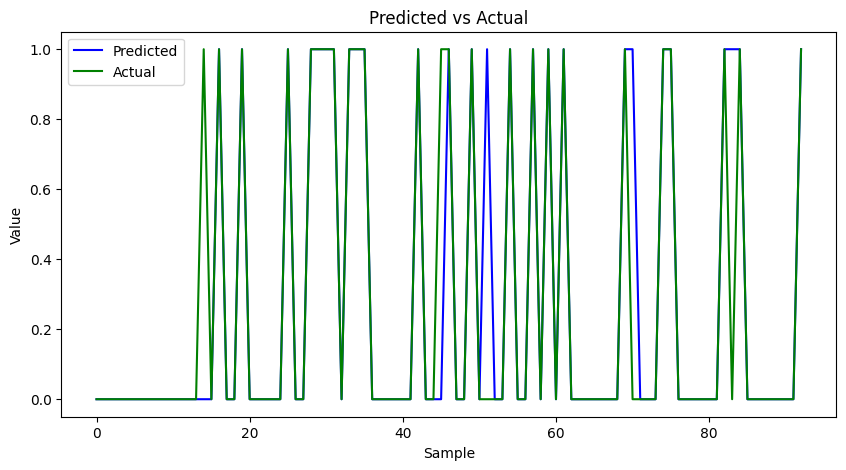

In [58]:
def analyze_model_on_test_set(
    test_df: pd.DataFrame,
    sequence_cols: list,
    sequence_length: int,
    label_col: str,
    model_path: str,
    batch_size_eval: int = 50,
    batch_size_pred: int = 200,
    save_predictions: bool = False,
    predictions_path: str = 'binary_submit_test.csv',
    plot: bool = True
):
    """
    Evaluate a saved model on the test set using the last sequence of each engine.
    
    Returns a dictionary of metrics.
    """
    # Select last sequences
    last_test_seq = [
        test_df[test_df['id'] == engine_id][sequence_cols].values[-sequence_length:]
        for engine_id in test_df['id'].unique()
        if len(test_df[test_df['id'] == engine_id]) >= sequence_length
    ]
    last_test_seq = np.asarray(last_test_seq, dtype=np.float32)
    
    # Select corresponding labels
    y_mask = [len(test_df[test_df['id'] == engine_id]) >= sequence_length 
              for engine_id in test_df['id'].unique()]
    last_test_label = test_df.groupby('id')[label_col].nth(-1)[y_mask].values
    last_test_label = last_test_label.reshape(-1, 1).astype(np.float32)

    # Load model
    if not os.path.isfile(model_path):
        raise FileNotFoundError(f"Model file not found: {model_path}")
    model = load_model(model_path)
    print(f"Using model: {model_path}")

    # Evaluate
    start = time.time()
    loss, accuracy = model.evaluate(last_test_seq, last_test_label, verbose=2, batch_size=batch_size_eval)
    end = time.time()
    print(f"Total inference time: {end-start:.2f} secs")
    print(f"Test Accuracy: {accuracy:.4f}")

    # Predict
    y_pred = (model.predict(last_test_seq, batch_size=batch_size_pred) > 0.5).astype("int32")
    
    if save_predictions:
        pd.DataFrame(y_pred).to_csv(predictions_path, index=False)
        print(f"Predictions saved to {predictions_path}")

    # Confusion matrix, precision, recall, F1
    cm = confusion_matrix(last_test_label, y_pred)
    precision = precision_score(last_test_label, y_pred)
    recall = recall_score(last_test_label, y_pred)
    f1 = 2 * (precision * recall) / (precision + recall)
    
    print("Confusion matrix (x-axis: true, y-axis: predicted):")
    print(cm)
    print(f"Test Precision: {precision:.4f}\nTest Recall: {recall:.4f}\nTest F1-score: {f1:.4f}")

    # Optional plot
    if plot:
        plt.figure(figsize=(10, 5))
        plt.plot(y_pred, color="blue")
        plt.plot(last_test_label, color="green")
        plt.title("Predicted vs Actual")
        plt.ylabel("Value")
        plt.xlabel("Sample")
        plt.legend(["Predicted", "Actual"], loc="upper left")
        plt.show()

    return {
        "accuracy": accuracy,
        "confusion_matrix": cm,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }

# Usage
results_test = analyze_model_on_test_set(
    test_df=test_df,
    sequence_cols=sequence_cols_25,
    sequence_length=sequence_length,
    label_col='failure_within_w0',
    model_path=RNN_bi_path,
    save_predictions=True,
    plot=True
)


In [60]:
import numpy as np
import pandas as pd

engine_id = 1  # example engine
# Get all sequences for this engine
engine_sequences = np.array([
    seq for seq, id_val in zip(seq_list, train_df['id']) if id_val == engine_id
]).astype(np.float32)

# Predict probabilities using your trained model
y_pred_probs = RNN_fwd_2.predict(engine_sequences)

# Average across all sequences for this engine to get a single probability
prob_failure = np.mean(y_pred_probs)
print(f"Engine {engine_id} has {prob_failure*100:.1f}% chance of failure within next window")


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Engine 1 has 16.8% chance of failure within next window


In [65]:
! pip install tqdm

In [72]:
engine_probs = []

# Pre-group sequences by engine
from collections import defaultdict
engine_seq_dict = defaultdict(list)

for engine_id in train_df['id'].unique():
    sequences_for_engine = [
        seq for seq in sequence_generator(train_df[train_df['id']==engine_id], sequence_length, sequence_cols_25)
    ]
    engine_seq_dict[engine_id] = np.array(sequences_for_engine, dtype=np.float32)

# Now predict per engine safely
for engine_id, sequences in engine_seq_dict.items():
    if sequences.shape[0] == 0:
        continue  # skip engines without enough sequences
    y_pred_probs = RNN_fwd_2.predict(sequences, verbose=0)
    mean_prob = np.mean(y_pred_probs.squeeze())
    engine_probs.append([engine_id, mean_prob])

engine_prob_df = pd.DataFrame(engine_probs, columns=['engine_id', 'failure_probability'])


engine_prob_df

,engine_id,failure_probability
0,1,0.227215
1,2,0.117123
2,3,0.222702
3,4,0.232626
4,5,0.153443
...,...,...
95,96,0.097419
96,97,0.167720
97,98,0.267599
98,99,0.214650


In [70]:
engine_prob_df = pd.DataFrame(engine_probs, columns=['engine_id', 'failure_probability'])

# Correctly define file path as a string (no comma)
predictions_file_path = 'predictions_file.csv'

# Export to CSV
engine_prob_df.to_csv(predictions_file_path, index=False)

print(f"✅ Predictions saved to {predictions_file_path}")

✅ Predictions saved to predictions_file.csv


# Predicting Engine failure using Gradient Booster

In [76]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 266.2 kB/s  0:00:07 eta 0:00:01


In [74]:
import numpy as np

# Flatten sequences: concatenate features along time
X_flat = seq_set_f25.reshape(seq_set_f25.shape[0], -1)  # shape: (num_samples, sequence_length * num_features)
y = label_set_aligned  # already aligned with sequences


In [87]:
import numpy as np
import pandas as pd
import xgboost as xgb

# Features and target
X = train_df[sequence_cols_25].values
y = train_df['failure_within_w0'].values

# Train XGBoost
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss'
)
xgb_clf.fit(X, y)

# Predict probabilities per row
y_probs = xgb_clf.predict_proba(X)[:, 1]

# Average probabilities per engine
engine_probs = train_df.assign(prob=y_probs).groupby('id')['prob'].mean().reset_index()
engine_probs.columns = ['engine_id', 'failure_probability']

# Save to CSV
engine_probs.to_csv('xgb_engine_probs.csv', index=False)

print(engine_probs)


/Users/frantzmoudoute/anaconda3/envs/jax-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[16:33:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




    engine_id  failure_probability
0           1             0.140364
1           2             0.099941
2           3             0.165653
3           4             0.164387
4           5             0.117925
..        ...                  ...
95         96             0.092396
96         97             0.147936
97         98             0.135462
98         99             0.129778
99        100             0.155861

[100 rows x 2 columns]


# Comparing Engine Prediction result from RNN vs GradientBooster

In [90]:
# Rename columns so they are clear
engine_prob_df.rename(columns={'failure_probability': 'rnn_prob'}, inplace=True)
engine_probs.rename(columns={'failure_probability': 'xgb_prob'}, inplace=True)

# Merge on engine_id
combined_df = pd.merge(engine_prob_df, engine_probs, on='engine_id')

# Sort descending by XGBoost probability
combined_df_sorted = combined_df.sort_values(by='xgb_prob', ascending=False).reset_index(drop=True)

# Save to CSV if needed
combined_df_sorted.to_csv('engine_combined_probs.csv', index=False)

# Display
combined_df_sorted


,engine_id,rnn_prob,xgb_prob
0,22,0.235942,0.235558
1,19,0.308213,0.232724
2,16,0.257002,0.228697
3,91,0.475138,0.224560
4,62,0.278922,0.223780
...,...,...,...
95,92,0.124285,0.098768
96,59,0.135387,0.098725
97,7,0.148591,0.098155
98,95,0.116078,0.093593
